# Miststep 2: Bias from regressing on transformed variables

In [1]:
%pylab inline --no-import-all
import pandas as pd
from scipy import optimize
import seaborn as sns
from scipy import stats
from scipy.stats import yeojohnson
import statsmodels.formula.api as smf
sns.set(context='talk', style='darkgrid')
dpi=96

Populating the interactive namespace from numpy and matplotlib


In [2]:
def linear(x, slope, y_intercept):
    return x * slope + y_intercept
def exponential(X, a, b):
    return a * np.exp(b * X)
rng = np.random.default_rng(seed=99)
X = rng.normal(10, 3, 100)
err = rng.normal(0, 0.5, 100)
def true_fit(X):
    return 1.85 * 10 ** (0.18 * X - 1.8)
Y = np.power(10, np.log10(true_fit(X)) + err)

### Example: Regressing on permeability in log-space

Imagine, if you will, that you have been tasked with estimating permeability for a new prospect. You successfully convinced management to let you core one well for 100 ft, and you've now got per-foot measurements of porosity and permeability. Through some miracle, this 100 feet all belongs to one rock type, so you only need to come up with one equation converting porosity to permeability.

Now, if you're an acolyte of Winland or Jerry Lucia (and his handy book [Carbonate Reservoir Characterization](https://www.amazon.com/gp/product/B000PC6DW2/ref=dbs_a_def_rwt_hsch_vapi_tkin_p1_i0)), you like to do things in logarithmic space. Porosity can vary by an order of magnitude, after all, and permeability often varies by several decades in the reservoir.

So you start with a porosity histogram, maybe in linear space, maybe in log space, you can decide by setting scale='linear' or scale='log'.

[Text(0, 0.5, 'Number of samples'), None, Text(0.5, 0, 'Porosity bins')]

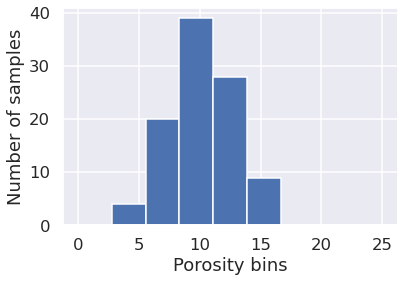

In [3]:
SCALE = 'linear'
if SCALE == 'linear':
    bins = np.linspace(0,25,10)
else: # SCALE == 'log'
    bins = np.logspace(0.5,1.5,10)
fig, ax0 = plt.subplots()
ax0.hist(X, bins)
ax0.set(xlabel='Porosity bins', xscale=SCALE, ylabel='Number of samples')

Looks roughly normal. 

Then a permeability histogram and a cross plot, once again, you get to decide whether to use linear or log scale, but for kicks let's look at linear.

[None, Text(0, 0.5, 'Permeability'), Text(0.5, 0, 'Porosity')]

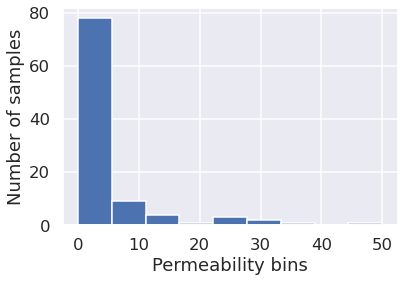

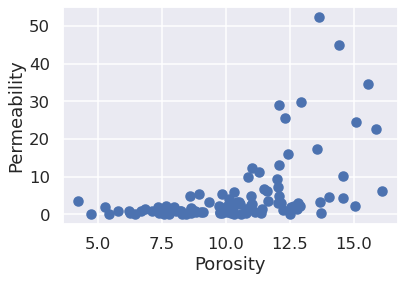

In [4]:
SCALE = 'linear'
if SCALE == 'linear':
    bins = np.linspace(0,50,10)
else: # SCALE=='log'
    bins = np.logspace(-2, 2,10)

fig, ax1 = plt.subplots()
ax1.hist(Y, bins)
ax1.set(xlabel='Permeability bins', xscale=SCALE, ylabel='Number of samples')

fig, ax2 = plt.subplots()
ax2.scatter(X, Y)
ax2.set(xlabel='Porosity', ylabel='Permeability', yscale=SCALE)

Hmm. Looks skewed in linear space, but great it log space. So you can see why permeability tends to be regressed on in logarithmic space.

Now, the next example is using a linear regression, but the same principle works if you're using a random forest or a neural network to predict permeability. The equation you are working with is
$$ \ln k = a \phi + b + \epsilon$$
where $a$ and $b$ are fitting parameters, and $\epsilon$ is the error term. In any type of regression model, you are trying to minimize
$$ \text{SSE} = \sum_{samples}(\ln k_{pred} - \ln k)^2$$
This is not the same as minimizing the error in $k_{pred}$. Instead, it is minimizing $\ln(k_{pred}/k)$. Therefore, a 50% error in $k=100$ is penalized precisely as much as a 50% error in $k=1$.

Below, we can see the effect this has in biasing prediction of $k$. In A, the regression is done in log space. In B, the log-space regression fit is compared to the true equation relating $k$ to $\phi$.

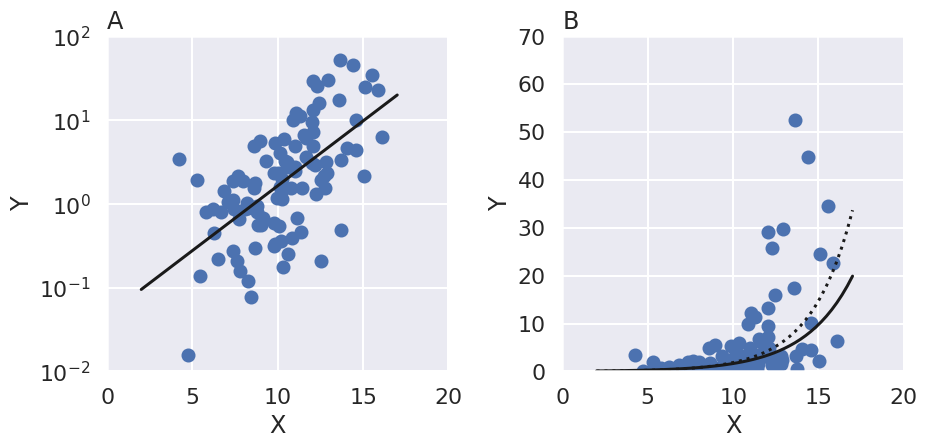

In [5]:
# Figure 6
figsize = (10, 5)

# regress in log space
(slope, intercept), _ = optimize.curve_fit(linear, X, np.log(Y))
X_line = np.linspace(2, 17, 50)
Y_biased = np.exp(slope * X_line + intercept)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax1.scatter(X, Y)
ax1.plot(X_line, Y_biased, 'k')
ax1.set(xlabel='X', xlim=(0, 20),
        ylabel='Y', yscale='log', ylim=(0.01, 100))
ax1.set_title('A', loc='left')

ax2.scatter(X, Y)
ax2.set(xlabel='X', xlim=(0, 20),
       ylabel='Y', ylim=(0, 70))
ax2.plot(X_line, Y_biased, 'k')

#true fit in linear space
ax2.plot(X_line, true_fit(X_line), ':k')
ax2.set_title('B', loc='left')
fig.tight_layout()

The solution to this problem is straightforward. Etnyre (1984) and Jensen et al. (2000, p. 212) have de-biasing methods. Jensen's approach requires assuming that the residuals are normally distributd. When that is true,
$$Y = 10^{aX + b} \exp[ (2.3 \sigma_e)^2 / 2]$$
where $\sigma_e$ is the standard deviation of the residuals.

Biased estimates in log space is a problem for permeability, formation factor, and pore throat size regression. This can manifest in incorrect porosity pay cutoff values and the need for permeability multipliers to history-match reservoir simulations.